In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 22 16:53:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:

import numpy as np
import torch
import torchvision
from torch.nn import Linear, ReLU, Dropout, Hardswish, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import v2
import skimage.io as io
from tempfile import TemporaryDirectory
import os
import time
from PIL import Image
import matplotlib.pyplot as plt


# Loading and preprocessing dataset

In [ ]:
cwd = os.getcwd()

In [ ]:

# data preprocessing pipeline

transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # convert PIL image to torch tensor - float32 [0,1]
    v2.Resize((224,224), interpolation=v2.InterpolationMode.NEAREST),  # resize images to 224x224
    ])


# downloading the dataset

pets_path_train = os.path.join(cwd,'dataset', 'train')
pets_path_test = os.path.join(cwd,'dataset', 'test')

training_data = datasets.OxfordIIITPet(
    root=pets_path_train,
    split='trainval',
    download=False,
    transform = transforms,
    target_types = ['category']
)

test_data = datasets.OxfordIIITPet(
    root=pets_path_test,
    split='test',
    download=False,
    transform = transforms,
    target_types = ['category']
)

# dataset is split into 50/50 for training and validation, we concatenate the datasets
# and redo the split for 80/20

all_dataset = ConcatDataset([training_data,test_data])
train_dataset,test_dataset = random_split(all_dataset, [0.8,0.2])
len(train_dataset), len(test_dataset)

(5880, 1469)

In [ ]:
t2img = v2.ToPILImage()
img2t = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


In [ ]:
# generating train and validation dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True)



In [ ]:

annot_dir = os.path.join(cwd,'dataset/train/oxford-iiit-pet/annotations')

# generating dictionary for classes
#[BREED, CLASS ID [1:37], SPECIES [1 CAT, 2 DOG], BREED ID [CAT [1:25], DOG[1:12]]]
with open(os.path.join(annot_dir,'trainval.txt'), 'r') as train_annot:
  targets = [line.strip().split() for line in train_annot.readlines()]

classes = {}

for pet in targets:
  pet[1] = int(pet[1])-1
  if pet[1] not in classes:
    classes[pet[1]] = '_'.join(pet[0].split('_')[:-1])


print('Classes dict:')
for pet_class in classes:
  print(f'{pet_class}:\t{classes[pet_class]}')

Classes dict:
0:	Abyssinian
1:	american_bulldog
2:	american_pit_bull_terrier
3:	basset_hound
4:	beagle
5:	Bengal
6:	Birman
7:	Bombay
8:	boxer
9:	British_Shorthair
10:	chihuahua
11:	Egyptian_Mau
12:	english_cocker_spaniel
13:	english_setter
14:	german_shorthaired
15:	great_pyrenees
16:	havanese
17:	japanese_chin
18:	keeshond
19:	leonberger
20:	Maine_Coon
21:	miniature_pinscher
22:	newfoundland
23:	Persian
24:	pomeranian
25:	pug
26:	Ragdoll
27:	Russian_Blue
28:	saint_bernard
29:	samoyed
30:	scottish_terrier
31:	shiba_inu
32:	Siamese
33:	Sphynx
34:	staffordshire_bull_terrier
35:	wheaten_terrier
36:	yorkshire_terrier


In [ ]:
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

In [ ]:
dataset_sizes

{'train': 5880, 'val': 1469}

In [ ]:
input_batch, target_batch = next(iter(train_dataloader))

In [ ]:
input_batch.size(), target_batch

(torch.Size([16, 3, 224, 224]),
 tensor([28, 17, 36,  5, 13, 26, 31, 23,  1, 14,  4, 32, 21, 14, 34, 32]))

## Visualising an image batch

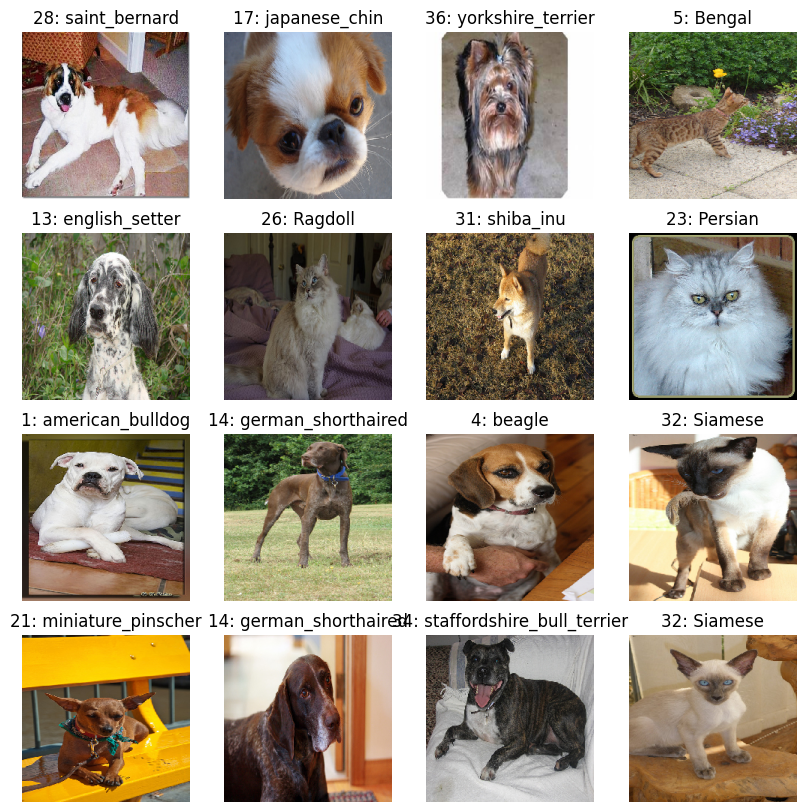

In [ ]:

plt.figure(figsize = [10,10])
for i in range(0,16):
  plt.subplot(4,4,i+1)
  plt.imshow(t2img(input_batch[i]))
  plt.title(f'{target_batch[i].item()}: {classes[target_batch[i].item()]}')
  plt.axis('off')


# Training the model

In [ ]:
# importing pretrained MobileNet model
mobilenet_model = torchvision.models.mobilenet_v3_large(weights = 'IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 84.5MB/s]


In [ ]:
# replacing the classifier layer according to the number of classes

mobilenet_model.classifier = torch.nn.Sequential(
    Linear(in_features=960, out_features=1280, bias=True),
    Hardswish(),
    Dropout(p=0.2, inplace=True),
    Linear(in_features=1280, out_features=37, bias=True)
)

In [ ]:
# loading model onto gpu

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

mobilenet_model = mobilenet_model.to(device)

cuda:0


In [ ]:
# defining hyperparameters

epochs = 10
losses = []
lrate = 1e-3
loss_func = CrossEntropyLoss()
optimizer = Adam(mobilenet_model.parameters())
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
best_acc = 0
best_model_params_path = os.path.join(root_dir,'best_model')

dataloaders = {'train': train_dataloader, 'val': test_dataloader}



In [ ]:
# defining training loop

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
# training the model

mobilenet_model = train_model(mobilenet_model, loss_func, optimizer, scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 1.2949 Acc: 0.5971
val Loss: 0.9495 Acc: 0.6998

Epoch 1/9
----------
train Loss: 0.6022 Acc: 0.8048
val Loss: 0.9024 Acc: 0.7447

Epoch 2/9
----------
train Loss: 0.3600 Acc: 0.8804
val Loss: 0.8033 Acc: 0.7577

Epoch 3/9
----------
train Loss: 0.3049 Acc: 0.8951
val Loss: 0.8225 Acc: 0.7726

Epoch 4/9
----------
train Loss: 0.1880 Acc: 0.9384
val Loss: 0.5760 Acc: 0.8393

Epoch 5/9
----------
train Loss: 0.1065 Acc: 0.9663
val Loss: 0.5687 Acc: 0.8393

Epoch 6/9
----------
train Loss: 0.0712 Acc: 0.9779
val Loss: 0.6429 Acc: 0.8237

Epoch 7/9
----------
train Loss: 0.0614 Acc: 0.9808
val Loss: 0.7307 Acc: 0.8257

Epoch 8/9
----------
train Loss: 0.0547 Acc: 0.9825
val Loss: 0.5599 Acc: 0.8632

Epoch 9/9
----------
train Loss: 0.0307 Acc: 0.9889
val Loss: 0.6722 Acc: 0.8502

Training complete in 71m 9s
Best val Acc: 0.863172


In [ ]:
# saving model state

mobilenet_params_path = os.path.join(cwd,'models/mobilenet/mobilenet_model')
torch.save(mobilenet_model.state_dict(),mobilenet_params_path)


## Loading saved model

In [ ]:
%%capture

mobilenet_model = torchvision.models.mobilenet_v3_large(weights = 'IMAGENET1K_V2')
mobilenet_model.classifier = torch.nn.Sequential(
    Linear(in_features=960, out_features=1280, bias=True),
    Hardswish(),
    Dropout(p=0.2, inplace=True),
    Linear(in_features=1280, out_features=37, bias=True)
)

mobilenet_model.load_state_dict(torch.load(mobilenet_params_path))
mobilenet_model.eval()

### Applying loaded model to batch of images

In [ ]:
input, label = next(iter(test_dataloader))
output = mobilenet_model(input)

In [ ]:
y_true = [classes[i] for i in label.cpu().numpy()]
y_pred = [classes[i] for i in torch.max(output,1)[1].cpu().numpy()]

predictions = list(zip(y_pred, y_true))

In [ ]:
plt.figure(figsize = [15,15])
for i in range(len(input)):
  plt.subplot(4,4,i+1)
  plt.imshow(t2img(input[i]))
  plt.title(f'{predictions[i][1]}\nprediction: {predictions[i][0]}')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.